# Debugging OpenCL applications

Debugging OpenCL applications has traditionally been a difficult topic. However there are some tools and techniques to help. These tools are:

* Checking the error codes on every OpenCL call
* Checking memory access from within kernels
* Visual inspection of outputs
* Using **printf** within kernels
* Using **Oclgrind** to check memory access violations

We will introduce an **intentional bug** into our matrix multiplication program and see if we can find it. In this instance we intentionally remove the guard check that protects the kernel from running off the end of buffer **C**. The size of matrices **A**, **B**, and **C** have chosen to be (72,72) with a local size of (4,16). Along dimension 0 an exact number of workgroups (18) can fit into the desired local size of 72. However, along dimension 1 the global size must be increased to 80 in order for an integer number of workgroups to fit. If we do not have a guard in place then array accesses into the matrices will run off the ends, resulting in a memory access violation.

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/matrix_boundaries.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Running off the end of the array due to differences between array size and global size.</figcaption>
</figure>

```C++
// kernels_mat_mult_badmem.c source

// standard matrix multiply kernel 
__kernel void mat_mult (__global float* A, 
                        __global float* B, 
                        __global float* C, 
                        unsigned int N1_A, 
                        unsigned int N0_C,
                        unsigned int N1_C) { 
            
    // C is of size (N0_C, N1_C)
    
    // i0 and i1 represent the coordinates in Matrix C 
    // We assume row-major ordering for the matrices 
    size_t i0=get_global_id(0); 
    size_t i1=get_global_id(1); 
    
    // Scratch variable
    float temp=0.0; 

    // Guard mechanism to make sure we do not go
    // outside the boundaries of matrix C
    
    // Comment out the guard mechanism 
    // to make sure we do not go
    // outside the boundaries of matrix C 
    
    //if ((i0<N0_C) && (i1<N1_C)) {
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            
            // Loop across row i0 of A
            // and down column i1 of B
            temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
        } 
        // Number of rows in C is same as number of rows in A
        C[i0*N1_C+i1]=temp;
    //}
} 
```

## Construct inputs

As before we construct the arrays for input.

In [1]:
import numpy as np

from matplotlib import pyplot as plt

%matplotlib widget

# A is of size (NROWS_C, NCOLS_A)
# B is of size (NCOLS_A, NCOLS_C)    
# C is of size (NROWS_C, NCOLS_C)

NCOLS_A = 72
NROWS_C = 72
NCOLS_C = 72

# Data type
dtype = np.float32

# Make up the arrays A, B, and C
A = np.random.random(size = (NROWS_C, NCOLS_A)).astype(dtype)
B = np.random.random(size = (NCOLS_A, NCOLS_C)).astype(dtype)

# Make up the answer
C = np.matmul(A, B, dtype = dtype)

# Write out the arrays as binary files
A.tofile("array_A.dat")
B.tofile("array_B.dat")

## Run the buggy application

In [2]:
!make clean; make; ./mat_mult_badmem.exe

rm -r *.exe
g++ -g -O0 -fopenmp -I/usr/include -I../include -L/usr/lib64 mat_mult.cpp\
	-o mat_mult.exe -lOpenCL -lomp
In file included from /usr/include/CL/cl.h:20,
                 from /usr/include/CL/opencl.h:24,
                 from ../include/cl_helper.hpp:11,
                 from mat_mult.cpp:16:
/usr/include/CL/cl_version.h:22:104: note: ‘#pragma message: cl_version.h: CL_TARGET_OPENCL_VERSION is not defined. Defaulting to 300 (OpenCL 3.0)’
   22 | _TARGET_OPENCL_VERSION is not defined. Defaulting to 300 (OpenCL 3.0)")
      |                                                                       ^

In file included from mat_mult.cpp:16:
../include/cl_helper.hpp: In function ‘_cl_command_queue** h_create_command_queues(_cl_device_id**, _cl_context**, cl_uint, cl_uint, cl_bool, cl_bool)’:
../include/cl_helper.hpp:260:49: warning: ‘_cl_command_queue* clCreateCommandQueue(cl_context, cl_device_id, cl_command_queue_properties, cl_int*)’ is deprecated []8;;https://gcc.gnu.org/onli

Notice that with some OpenCL implementations the code completes without crashing. This is because some OpenCL frameworks (GPU ones in particular) do not have accurate memory access violation checks. Memory access violations can result in undefined behaviour. Due to OS security, CPU implementations are more sensitive to memory access violations than others. This means CPU-based implementations are better to develop with.

## Visual inspection of outputs

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
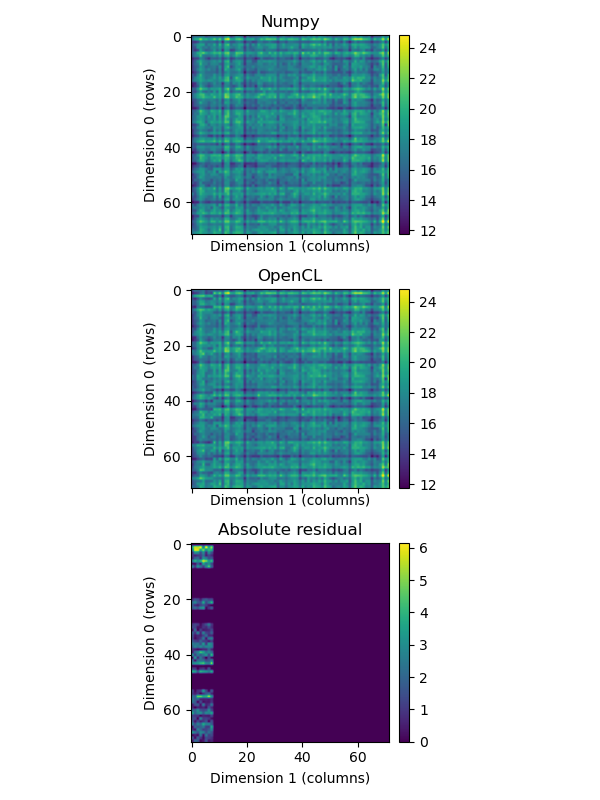

In [3]:
# Import axes machinery
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Read in the output from OpenCL
C_ocl = np.fromfile("array_C.dat", dtype=dtype).reshape((NROWS_C, NCOLS_C))

# Make plots
fig, axes = plt.subplots(3, 1, figsize=(6,8), sharex=True, sharey=True)

# Data to plot
data = [C, C_ocl, np.abs(C-C_ocl)]

# Labels to plot
labels = ["Numpy", "OpenCL", "Absolute residual"]

for n, value in enumerate(data):
    # Plot the graph
    ax = axes[n]
    im = ax.imshow(value)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # Set labels on things
    ax.set_xlabel("Dimension 1 (columns)")
    ax.set_ylabel("Dimension 0 (rows)")
    ax.set_title(labels[n])

    # Put a color bar on the plot
    plt.colorbar(mappable=im, cax=cax)

fig.tight_layout()
plt.show()

Running off the end of the array is obvious in this instance because it affects the first 8 cells of next row. That is why 8 cells are affected on the left hand side of the array.

## Checking OpenCL calls 

Inspecting the return codes of OpenCL calls is good practice for programming with OpenCL. Many API errors are caught this way. In this lesson we have already checked return codes and they haven't signalled an error. We need to dig deeper.

## Checking memory access by filling with known values

When trying to get your OpenCL codes working it is helpful to first make sure that your memory accesses are valid. In this instance we change the kernel to [kernels_mat_mult_memcheck.c](kernels_mat_mult_memcheck.c) so that it fills **C** with a known value. In this case we fill it with **i1**. Run the code and check the results by running the visual check above.

In [7]:
!make; ./mat_mult_memcheck.exe

make: Nothing to be done for 'all'.
	               name: NVIDIA GeForce RTX 3060 
	 global memory size: 12636 MB
	    max buffer size: 3159 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024


Some lines are filled with higher values of **i1** whereas others are filled with lower values. This shows that one cannot rely on the order in which workgroups complete and the order in which memory adjustments are flushed back to global memory.

## Debugging with **printf**

Most of the major OpenCL implementations including POCL, NVIDIA, AMD, and INTEL allow the use of a **printf** statement within a kernel. Output from printf in the kernel gets routed to standard output on the command line. We edit the kernel source in file [kernels_mat_mult_printf.c](kernels_mat_mult_printf.c) to include a printf statement that triggers whenever we exceed the size of the matrices along dimension 1.

```C
// standard matrix multiply kernel 
__kernel void mat_mult (__global float* A, 
                        __global float* B, 
                        __global float* C, 
                        unsigned int N1_A, 
                        unsigned int N0_C,
                        unsigned int N1_C) { 
            
    // C is of size (N0_C, N1_C)
    
    // i0 and i1 represent the coordinates in Matrix C 
    // We assume row-major ordering for the matrices 
    size_t i0=get_global_id(0); 
    size_t i1=get_global_id(1); 
    
    // Scratch variable
    float temp=0.0; 

    // Comment out the guard mechanism 
    // to make sure we do not go
    // outside the boundaries of matrix C
    if (i1>N1_C-1) {
        printf("i1 is %d\n", i1);
    }
    
    //if ((i0<N0_C) && (i1<N1_C)) {
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            
            // Loop across row i0 of A
            // and down column i1 of B
            temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
        } 
        // Number of rows in C is same as number of rows in A
        C[i0*N1_C+i1]=temp;
    //}
}
```

Now run the program and observe that the workgroups do indeed encounter values of **i1** that go beyond the bounds of the array.

In [9]:
!make; ./mat_mult_printf.exe

make: Nothing to be done for 'all'.
	               name: Intel(R) FPGA Emulation Device 
	 global memory size: 135007 MB
	    max buffer size: 33751 MB
	     max local size: (67108864,67108864,67108864)
	     max work-items: 67108864
i1 is 72
i1 is 73
i1 is 74
i1 is 75
i1 is 76
i1 is 77
i1 is 78
i1 is 79


## Debugging and validation with Oclgrind

[Oclgrind](https://github.com/jrprice/Oclgrind) simulates an OpenCL device that self-checks for data races, memory access violations, and erroneous API runtime calls. It currently provides an OpenCL 1.2 interface as well as **gdb-like** interactive kernel debugging. Oclgrind is exactly what the OpenCL community needs for interactive debugging of kernels, however it is **orders of magnitude** slower than a native OpenCL application, so you need to make problem sizes really small, as we have done, or you can have a setting **-q** to just compute the first and last workgroups.

### Memory access checking

If you run **oclgrind** with the application as an argument then it intercepts OpenCL library calls that the application makes, and provides a sole OpenCL device that checks for errors. 

In [8]:
!oclgrind ./mat_mult_badmem.exe

	               name: Oclgrind Simulator 
	 global memory size: 134 MB
	    max buffer size: 134 MB
	     max local size: (1024,1024,1024)
	     max work-items: 1024
1 warning generated.

Invalid read of size 4 at global memory address 0x2000000005100
	Kernel: mat_mult_badmem
	Entity: Global(8,72,0) Local(0,8,0) Group(2,4,0)
	  %1 = load float, float addrspace(1)* %arrayidx7, align 4, !dbg !58, !tbaa !48
	At line 68 (column 32) of input.cl:
	  temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
	

Invalid read of size 4 at global memory address 0x2000000005100
	Kernel: mat_mult_badmem
	Entity: Global(36,72,0) Local(0,8,0) Group(9,4,0)
	  %1 = load float, float addrspace(1)* %arrayidx7, align 4, !dbg !58, !tbaa !48
	At line 68 (column 32) of input.cl:
	  temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
	

Invalid read of size 4 at global memory address 0x2000000005100
	Kernel: mat_mult_badmem
	Entity: Global(44,72,0) Local(0,8,0) Group(11,4,0)
	  %1 = load float, float addrspace(1)* %arrayidx7, align 4, !dbg !58, !tbaa

From the error messages we have very clear indications that both read and write memory access violations are taking place.

### Interactive debugging with **Oclgrind**

Oclgrind provides a powerful **gdb-like** debugging experience. The option **-i** allows for interactive line-by-line walkthroughs of kernels and we are going to step through each line of our buggy kernel.

1. Open a terminal and run oclgrind like this
```bash
oclgrind -i ./mat_mult_badmem.exe
```
1. Within Oclgrind display all available commands using the **help** command
```bash
help
```
1. Use the **next** command to step through the lines of the kernel arguments.
1. Use the **print** command to print out the value of the input variables **N0_C** and **N1_C**.
```bash
print N0_C
```
1. Again use the print command to examine the value of buffer **B** at index 1. The value should be betwen 0 and 1.
```bash
print B[1]
```
1. Get help on the **wi** command
```bash
help wi
```
1. Move to work item (0, 72, 0) and **continue** until you get a memory access violation
```bash
wi 0 72 0
continue
```
1. Print the value of **n**, **i0** and **i1** and locate in which array the memory read access violation occurred
```bash
print n
print i0
print i1
```
1. Quit the application
```bash
quit
```

### Kernel-specific debugging

Sometimes you might have one kernel to debug within a large program. If you only wish to debug a specific kernel without having to run an application there is the **oclgrind-kernel** application. It takes in a file specifying the runtime parameters and kernel arguments, and runs that kernel using the OpenCL device simulator. As follows is the contents of [mat_mult_badmem.sim](mat_mult_badmem.sim).

```bash
kernels_mat_mult_badmem.c # File containing OpenCL program (can be OpenCL C or SPIR)
mat_mult    # Name of the kernel to run
72 80 1     # NDRange
4 16 1      # Work-group size

# First argument 'global float *A'
# Alocation of 72*72*4 = 20736 
# bytes filled with 1's of type float
<size=20736 fill=1 float>

# Second argument 'global float *B' 
# Same size but filled with floats 
# in the range 0:5183 inclusive
<size=20736 range=0:1:5183 float>

# Third argument 'global float *C' 
# filled with zeros and type float
<size=20736 fill=0 float>

# Fourth argument integer N1_A
<size=4 uint>
72

# Fifth argument integer N0_C
<size=4 uint>
72

# Sixth argument integer N1_C
<size=4 uint>
72
```

Running the simulation then takes the form

```bash
oclgrind-kernel ./mat_mult_badmem.exe
```

for memory access checks, and for interactive debugging we run

```bash
oclgrind-kernel -i ./mat_mult_badmem.exe
```

and proceed with debugging as before.

## Vendor-specific tools

### NVIDIA

NVIDIA's OpenCL solution runs on NVIDIA hardware. While NVIDIA has very little explicit support for OpenCL in terms of development tools, their implemenation is mature and conformant with the latest 3.0 spec as well as having a significant number of accompanying examples. Debgugging tools for CUDA can provide insight into the processes at work on the GPU.

#### Debugging with cuda-gdb

Running the code under cuda-gdb is accompished with the command

```bash
cuda-gdb ./mat_mult_badmem.exe
```

Debugging on the host code can proceed as per normal but I haven't found a way to access the kernel. At the time of writing this tool didn't detect the memory access violations.

#### Memory access checking with cuda-memcheck

The CUDA memory checking tool **cuda-memcheck** is designed to check for race conditions, synchronisation errors, memory initialisation problems, and memory access violations. Memory checking works for both OpenCL and CUDA applications using the following call. We need to make sure we are using the NVIDIA compute device though.

In [1]:
!cuda-memcheck ./mat_mult_badmem.exe

========= CUDA-MEMCHECK
	               name: NVIDIA GeForce RTX 3060 
	 global memory size: 12636 MB
	    max buffer size: 3159 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
	               name: gfx906:sramecc+:xnack- 
	 global memory size: 17163 MB
	    max buffer size: 14588 MB
	     max local size: (1024,1024,1024)
	     max work-items: 256
	               name: pthread-AMD Ryzen Threadripper 2950X 16-Core Processor 
	 global memory size: 132854 MB
	    max buffer size: 34359 MB
	     max local size: (4096,4096,4096)
	     max work-items: 4096
	               name: Intel(R) FPGA Emulation Device 
	 global memory size: 135002 MB
	    max buffer size: 33750 MB
	     max local size: (67108864,67108864,67108864)
	     max work-items: 67108864
	               name: AMD Ryzen Threadripper 2950X 16-Core Processor  
	 global memory size: 135002 MB
	    max buffer size: 33750 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
========= Invalid __globa

We see that cuda-memcheck is catching the memory access error, but we don't have an in-depth look at what is happening in the kernel.

### AMD

AMD has the **rocgdb** debugger available, which can debug kernels being run on the GPU. I was neither able to get it to work nor find out how to debug OpenCL kernels with it however.

### Intel

The [OneAPI toolkit](https://www.intel.com/content/www/us/en/developer/tools/oneapi/toolkits.html#base-kit) has an enhanced GDB debugger that has the ability to step through and debug OpenCL kernels. It works with the [Intel OpenCL runtime](https://www.intel.com/content/www/us/en/developer/articles/tool/opencl-drivers.html#cpu-section). Incidentally, the standard **GDB** debugger also works to debug kernels on the CPU runtime.

#### Debugging with GDB

In order to enable kernel debugging we need to select the Intel OpenCL CPU device set the following OpenCL build options at program compilation. 
```bash
-g -s /path/to/kernel.cl -cl-opt-disable
```
The **"-s"** flag is to tell the runtime where the kernel source is and the **"-g"** is to enable debugging symbols. Both "-g" and "-s" flags appear to be Intel-specific compiler options and don't seem to work with other implementations. We set these options in the source file [mat_mult_badmem_gdb.cpp](mat_mult_badmem_gdb.cpp) as an additional argument to the **h_build_program** helper function.

```C++
    // Turn this source code into a program
    cl_program program = h_build_program(
        kernel_source, 
        context, 
        device,
        // Put debugging information here
        // -g and -s flags are Intel-specifc
        "-g -s kernels_mat_mult_badmem.c -cl-opt-disable"
    );
```

Then we can run **gdb-oneapi** if you have the OneAPI toolkit (or just **gdb** if you don't) to start the program

```bash
gdb ./mat_mult_badmem_gdb.exe
```

Within the kernel there are three variables we can use to specify a breakpoint.

* __ocl_dbg_gid0
* __ocl_dbg_gid1
* __ocl_dbg_gid2

They represent the global id for dimensions 1, 2, and 3 during kernel execution. We can use these at gdb command line to set a specific breakpoint in the kernel. In this case we set execution to halt with when a kernel with **(__ocl_dbg_gid0 == 0) and (__ocl_dbg_gid1 == 72)** executes. 

```bash
break kernels_mat_mult_badmem.c:15 if (__ocl_dbg_gid0 == 0) && (__ocl_dbg_gid1 == 72)
```

Ignore the warning about shared library loading. The kernel source code is yet to be loaded. Now run the code

```bash
run
```

and it should stop at the correct work-item. We now have all the same debugging commands available as with Oclgrind and even new abilities such as being able to set variables.

```bash
set temp=0
```

Now enter 

```bash
quit
```

to exit the program. I noticed that the Intel implementation doesn't detect the memory error as a memory access violation.